In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip

# Combine the two traning directories
!echo "Mergining training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip

!echo "Data ready."

Unzipping files...
Mergining training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
import os



In [3]:
# Create an image training dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

# We're using keras' image_dataset_from_directory method to load our image data.
# See (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 

training_dir = '/content/training'
image_size = (100, 100)
training_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='training', seed=512, image_size=image_size)
val_data = image_dataset_from_directory(training_dir, validation_split=0.2, subset='validation', seed=512, image_size=image_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


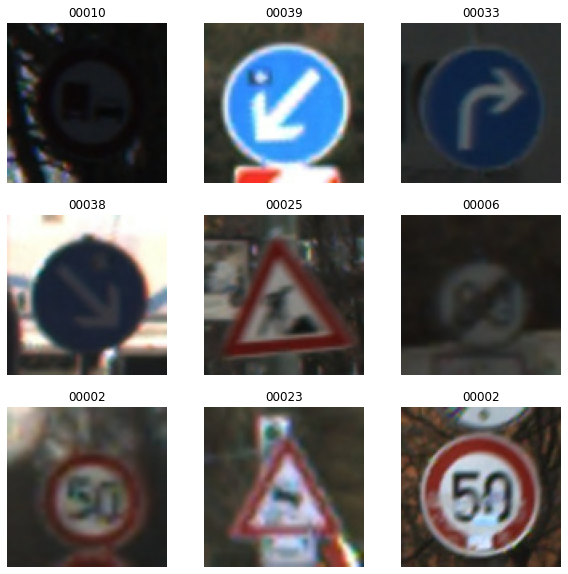

In [11]:
import matplotlib.pyplot as plt

# View first 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(training_data.class_names[labels[i]])
    plt.axis("off")

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(44, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


87916544/87910968 [==============================] - 1s 0us/step


In [5]:
epochs = 20
history = model.fit(
    training_data,
    validation_data = val_data,
    epochs=epochs
)

Epoch 1/20
981/981 [==============================] - 43s 44ms/step - loss: 8.8258 - accuracy: 0.1290 - val_loss: 3.0922 - val_accuracy: 0.1760
Epoch 2/20
981/981 [==============================] - 42s 42ms/step - loss: 3.2249 - accuracy: 0.1642 - val_loss: 3.5914 - val_accuracy: 0.1687
Epoch 3/20
981/981 [==============================] - 42s 43ms/step - loss: 3.1377 - accuracy: 0.1760 - val_loss: 3.2388 - val_accuracy: 0.2079
Epoch 4/20
981/981 [==============================] - 42s 43ms/step - loss: 3.1609 - accuracy: 0.1864 - val_loss: 3.0024 - val_accuracy: 0.1927
Epoch 5/20
981/981 [==============================] - 42s 43ms/step - loss: 3.1757 - accuracy: 0.1924 - val_loss: 3.0424 - val_accuracy: 0.2023
Epoch 6/20
981/981 [==============================] - 42s 43ms/step - loss: 3.1341 - accuracy: 0.1910 - val_loss: 3.0829 - val_accuracy: 0.2012
Epoch 7/20
981/981 [==============================] - 42s 43ms/step - loss: 3.1215 - accuracy: 0.1992 - val_loss: 3.0941 - val_accuracy:

In [7]:
model.save('/content/drive/MyDrive/Machine Learning/Module 6/Checkpoints/toplayerstrained.h5')

In [8]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
epochs = 60
history = model.fit(
    training_data,
    validation_data = val_data,
    epochs=epochs
)
model.save('/content/drive/MyDrive/Machine Learning/Module 6/Checkpoints/fifthset.h5')

Epoch 1/60
981/981 [==============================] - 51s 52ms/step - loss: 3.2485 - accuracy: 0.1953 - val_loss: 2.7655 - val_accuracy: 0.2645
Epoch 2/60
981/981 [==============================] - 49s 50ms/step - loss: 2.7216 - accuracy: 0.2719 - val_loss: 2.5075 - val_accuracy: 0.3232
Epoch 3/60
981/981 [==============================] - 49s 50ms/step - loss: 2.5246 - accuracy: 0.3206 - val_loss: 2.3666 - val_accuracy: 0.3623
Epoch 4/60
981/981 [==============================] - 49s 50ms/step - loss: 2.3734 - accuracy: 0.3641 - val_loss: 2.2408 - val_accuracy: 0.4089
Epoch 5/60
981/981 [==============================] - 48s 49ms/step - loss: 2.2612 - accuracy: 0.3936 - val_loss: 2.1312 - val_accuracy: 0.4253
Epoch 6/60
981/981 [==============================] - 48s 49ms/step - loss: 2.1447 - accuracy: 0.4302 - val_loss: 2.0583 - val_accuracy: 0.4559
Epoch 7/60
981/981 [==============================] - 48s 49ms/step - loss: 2.0639 - accuracy: 0.4476 - val_loss: 1.9884 - val_accuracy:

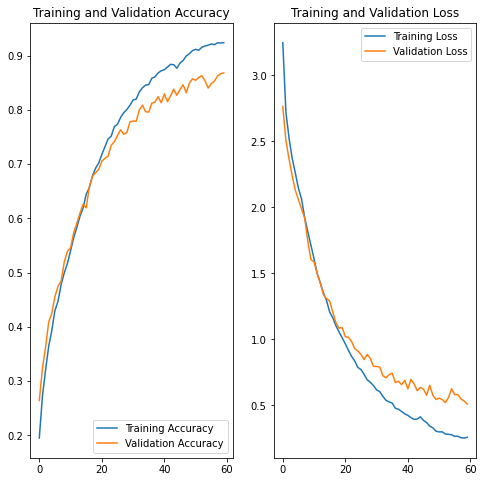

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()